# Exercise 3.8
Download from figshare [this flows dataset](https://figshare.com/collections/Inter-urban_interactions_of_mobility_via_cellular_position_tracking_in_the_southeast_Songliao_Basin_Northeast_China/4226183), create a tessellation
and a FlowDataFrame; plot them together using skmob.
* [This article](https://www.nature.com/articles/s41597-019-0070-1) describes the dataset.
* Create a json file using the data module ([doc](https://scikit-mobility.github.io/scikit-mobility/reference/data.html)) to upload the
dataset on skmob
* Submit a (well documented) notebook and the json file of the
data module.

## Installing the libraries

In [ ]:
# correct order to avoid errors
!pip install Shapely
!pip install folium
!pip install Fiona
!pip install pyproj
!pip install rtree
!pip install pygeos
!pip install scikit-mobility
!pip install -U geopandas #scikit mobilty force the installation of geopandas 0.9 for compatibiltiy but that version doesn't have some features as "sjoin" from geopandas
!pip install geovoronoi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.7 MB 4.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.3 MB 4.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 5.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 154 kB 5.5 MB/s 
     |███████████████

## Importing the libraries

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np

import skmob
import folium
import random

import urllib.request

#to tessellate and plot tessellations
from skmob.tessellation.tilers import tiler
from skmob.utils.plot import plot_gdf

#for the Voronoi Tessellation
from scipy.spatial import Voronoi,voronoi_plot_2d
from geovoronoi import voronoi_regions_from_coords, points_to_coords
from shapely.geometry import *

## Writing the JSON on disk
There was a problem that there were two txt files to download

In [ ]:
import json, codecs

json_file = {
    "name":"Four_cities_zh",
    "description":"FlowDataFrame describing the movements of 3 million devices in 4 cities of the South-east Songliao Basin, North-east China",
    "url": "https://figshare.com/ndownloader/files/14884442",
    "hash":"1244411445db20bf6d9b496a7f51513f", 
    "data_type":"flow", 
    "auth":"no", 
    "download_format":"zip", 
    "sep":",", 
    "encoding":"ISO-8859-1"
}

with open('json_file.json', 'wb') as f:
    json.dump(json_file, codecs.getwriter('utf-8')(f), ensure_ascii=False)

Importing the json to test if it was read correctly

In [ ]:
with open('json_file.json', 'rb') as f:
    json_import = json.loads(f.read())
    
json_import

{'name': 'Four_cities_zh',
 'description': 'FlowDataFrame describing the movements of 3 million devices in 4 cities of the South-east Songliao Basin, North-east China',
 'url': 'https://figshare.com/ndownloader/files/14884442',
 'hash': '1244411445db20bf6d9b496a7f51513f',
 'data_type': 'flow',
 'auth': 'no',
 'download_format': 'zip',
 'sep': ',',
 'encoding': 'ISO-8859-1'}

## Downloading the files

In [ ]:
mobility_txt = json_import['url']
gps_txt = 'https://figshare.com/ndownloader/files/14005292'

#downloading the files from the figshare links
mob_file, _ = urllib.request.urlretrieve(mobility_txt, 'mob.txt')
gps_file, _ = urllib.request.urlretrieve(gps_txt, 'gps.txt')

## Opening the files

In [ ]:
flow_data = pd.read_csv(mob_file)
tess_data = pd.read_csv(gps_file)

In [ ]:
print(len(flow_data))
flow_data.head()

4685352


,Origin,Destination,Weight,Time
0,220102001000,220102001000,117,2017-08-07T01+08
1,220102001000,220102002000,1,2017-08-07T01+08
2,220102001000,220102003000,1,2017-08-07T01+08
3,220102001000,220102004000,1,2017-08-07T01+08
4,220102001000,220102005000,0,2017-08-07T01+08


In [ ]:
print(len(tess_data))
tess_data.head()

174


,Location,Latitude,Longitude
0,220102001000,43.853882,125.344108
1,220102002000,43.884234,125.331473
2,220102003000,43.881957,125.343187
3,220102004000,43.893253,125.342543
4,220102005000,43.899503,125.342342


In [ ]:
#getting the point shapes from latitude and longitude
points_recorded = gpd.points_from_xy(tess_data['Longitude'], tess_data['Latitude'])
#performing a unary union to get a single object
shape_points = points_recorded.unary_union()
#getting the convexhull of the points
poly_ch = shape_points.convex_hull

With a larger density of points inside it seems a Voronoi tessellation is more realistic, it may be that in origin they tessellated according to administrative subdivisions, but I do not have them



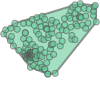

In [ ]:
#visualizing the geometries
point_hull = GeometryCollection([poly_ch, shape_points])
point_hull

## Get the Voronoi Tessellation
I used the class I wrote for exercise 3.2 and 3.3, adapting it for this exercise

In [ ]:
def to_GeoDataFrame(region_polys):
    tile_id=[]
    for i in range(len(region_polys)):
        tile_id.append(i)
    gdf = gpd.GeoDataFrame(columns=['tile_ID','geometry'], crs='epsg:4326')
    gdf['tile_ID'] = tile_id
    for index, row in gdf.iterrows():
        gdf.at[index, 'geometry'] = region_polys[index]
    return gdf

def flip_xy(point):
    return point.y, point.x 

class Voronoi_from_Points():
    #setting the constructor
    def __init__(self, pointDataFrame, border_precision=5000):
        #getting the point shapes from latitude and longitude
        points_recorded = gpd.points_from_xy(pointDataFrame['Longitude'], pointDataFrame['Latitude'])
        self.pointDataFrame = gpd.GeoDataFrame(pointDataFrame, geometry=points_recorded, crs='epsg:4326')
        #performing a unary union to get a single object
        shape_points = points_recorded.unary_union()
        #getting the convexhull of the points
        self.poly_ch = shape_points.convex_hull
        
        ### Getting the squared tessellation
        basic_tessellation = tiler.get('squared', base_shape=gpd.GeoDataFrame(geometry=[poly_ch], crs='epsg:4326'), meters=border_precision) #get basic borders of the city
        gdf_convexhull = gpd.GeoDataFrame(geometry=[poly_ch], crs = 'epsg:4326') #creating a gdf of the convex hull
        
        #getting the coordinates of the points
        coords = np.array(list(zip(points_recorded.x, points_recorded.y)))

        #performing the Voronoi tessellation
        vor = Voronoi(coords, qhull_options='Qbb Qc Qx')
        region_polys, region_pts = voronoi_regions_from_coords(points_recorded, poly_ch)
        self.tess_voronoi = to_GeoDataFrame(region_polys)

    #adding a method to directly plot the result as before
    def plot(self):
        mappa = folium.Map(location= flip_xy(self.poly_ch.centroid), zoom_start=9)
        voronoi_map = plot_gdf(self.tess_voronoi, map_f=mappa)
        return plot_gdf(self.pointDataFrame, map_f=mappa)

    def get_tess(self):
        return self.tess_voronoi

## Visualizing the Voronoi

In [ ]:
Voronoi_from_Points(tess_data).plot()

Image of the Result

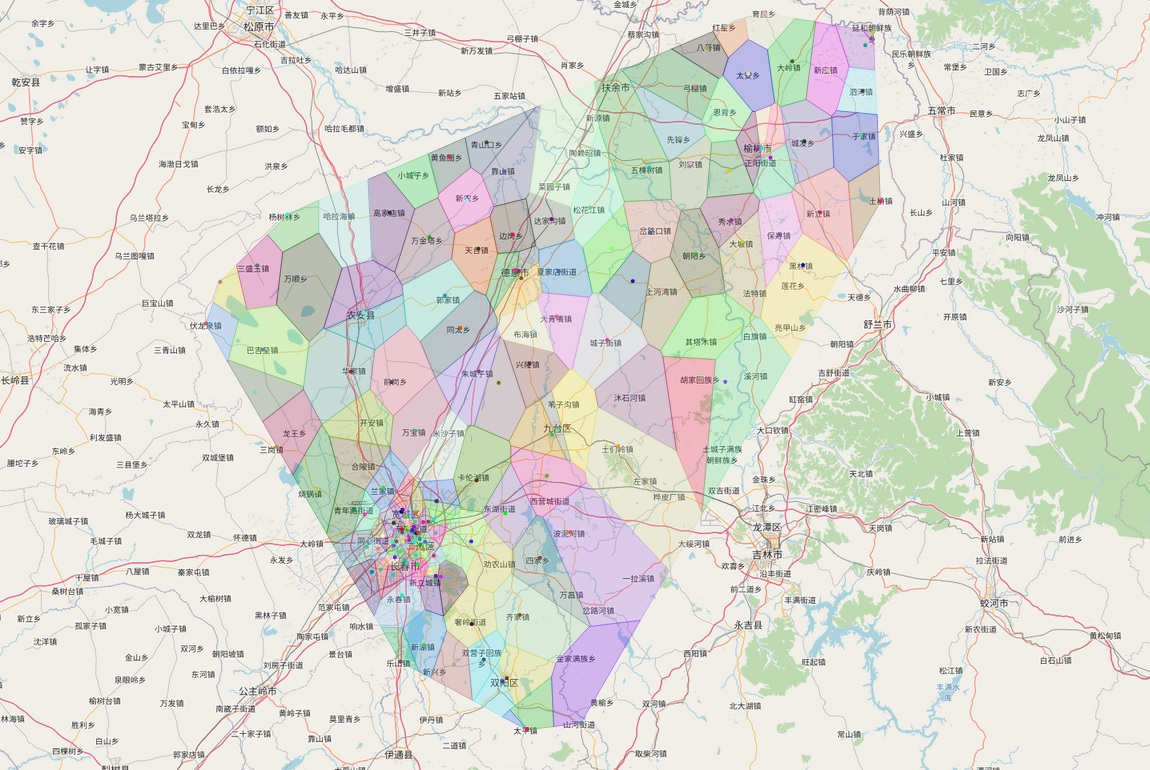

## Saving the Voronoi Tessellation

In [ ]:
voronoi_tess = Voronoi_from_Points(tess_data).get_tess()
voronoi_tess.head()

/usr/local/lib/python3.7/dist-packages/skmob/tessellation/tilers.py:117: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  base_shape = gpd.GeoSeries(cascaded_union(polygons), crs=base_shape.crs)


,tile_ID,geometry
0,0,"POLYGON ((124.65901 44.45908, 124.68331 44.509..."
1,1,"POLYGON ((124.74572 44.41765, 124.71258 44.317..."
2,2,"POLYGON ((125.69414 43.46363, 125.81998 43.533..."
3,3,"POLYGON ((125.81998 43.53364, 125.83031 43.411..."
4,4,"POLYGON ((125.31011 43.65525, 125.36572 43.548..."


## Performing a Spatial Join to get my Tiles match the original tile_ID

In [ ]:
## Putting the original data with the geometry inferred into a geoDataFrame
#using the point shapes I get before from latitude and longitude to create the GeoDataFrame
original_tile_df = gpd.GeoDataFrame(tess_data, geometry=points_recorded, crs='epsg:4326')
original_tile_df.head()

,Location,Latitude,Longitude,geometry
0,220102001000,43.853882,125.344108,POINT (125.34411 43.85388)
1,220102002000,43.884234,125.331473,POINT (125.33147 43.88423)
2,220102003000,43.881957,125.343187,POINT (125.34319 43.88196)
3,220102004000,43.893253,125.342543,POINT (125.34254 43.89325)
4,220102005000,43.899503,125.342342,POINT (125.34234 43.89950)


In [ ]:
#joining the voronoi and the original tiles without geometry to get the new tessellation
tessellation_df = gpd.sjoin(voronoi_tess, original_tile_df)
#sorting according to the original index and finally dropping the voronoi tile_ID and using the original one
tessellation_df = tessellation_df.sort_values('index_right')
#resetting the gdf index
tessellation_df = tessellation_df.reset_index(drop=True)
#also dropping the tile_ID which is just identical to the old index and I need only Location as the new tile_ID
tessellation_df = tessellation_df.drop(['index_right', 'tile_ID'], axis=1)
tessellation_df.head()

,geometry,Location,Latitude,Longitude
0,"POLYGON ((125.33933 43.86512, 125.35683 43.857...",220102001000,43.853882,125.344108
1,"POLYGON ((125.32540 43.87928, 125.32155 43.882...",220102002000,43.884234,125.331473
2,"POLYGON ((125.34126 43.87239, 125.35427 43.880...",220102003000,43.881957,125.343187
3,"POLYGON ((125.33465 43.89613, 125.34985 43.896...",220102004000,43.893253,125.342543
4,"POLYGON ((125.35155 43.89947, 125.34985 43.896...",220102005000,43.899503,125.342342


In [ ]:
fdf = skmob.FlowDataFrame(flow_data, 
                          origin='Origin', 
                          destination='Destination', 
                          flow='Weight', 
                          datetime='Time', 
                          tessellation=tessellation_df, 
                          tile_id='Location')
print('{:,} number of flow records'.format(len(fdf)))
fdf.head()

4,685,352 number of flow records


,origin,destination,flow,datetime
0,220102001000,220102001000,117,2017-08-07T01+08
1,220102001000,220102002000,1,2017-08-07T01+08
2,220102001000,220102003000,1,2017-08-07T01+08
3,220102001000,220102004000,1,2017-08-07T01+08
4,220102001000,220102005000,0,2017-08-07T01+08


## Plotting the flows
There are too many records to plot, I decided to plot only those with flows over 99.5% of the distribution (with a flow weight of 588)... Further more many of the flows are probably directed inside the same tile

In [ ]:
min_flow = fdf.quantile(0.995)[0]
min_flow

588.0

In [ ]:
print('Original records: {:,}\nRecords to plot: {:,}'.format(len(fdf), len(fdf[fdf['flow'] >= min_flow])))

Original records: 4,685,352
Records to plot: 23,453


In [ ]:
changchun_location = (43.8130735, 125.3171216)
flow_map = folium.Map(location=changchun_location, zoom_start=12, tiles = 'Stamen Toner')
plot_gdf(tessellation_df, map_f=flow_map)

#plotting the flows
fdf.plot_flows(map_f = flow_map, min_flow = min_flow, flow_weight=0.5)

Image of the result
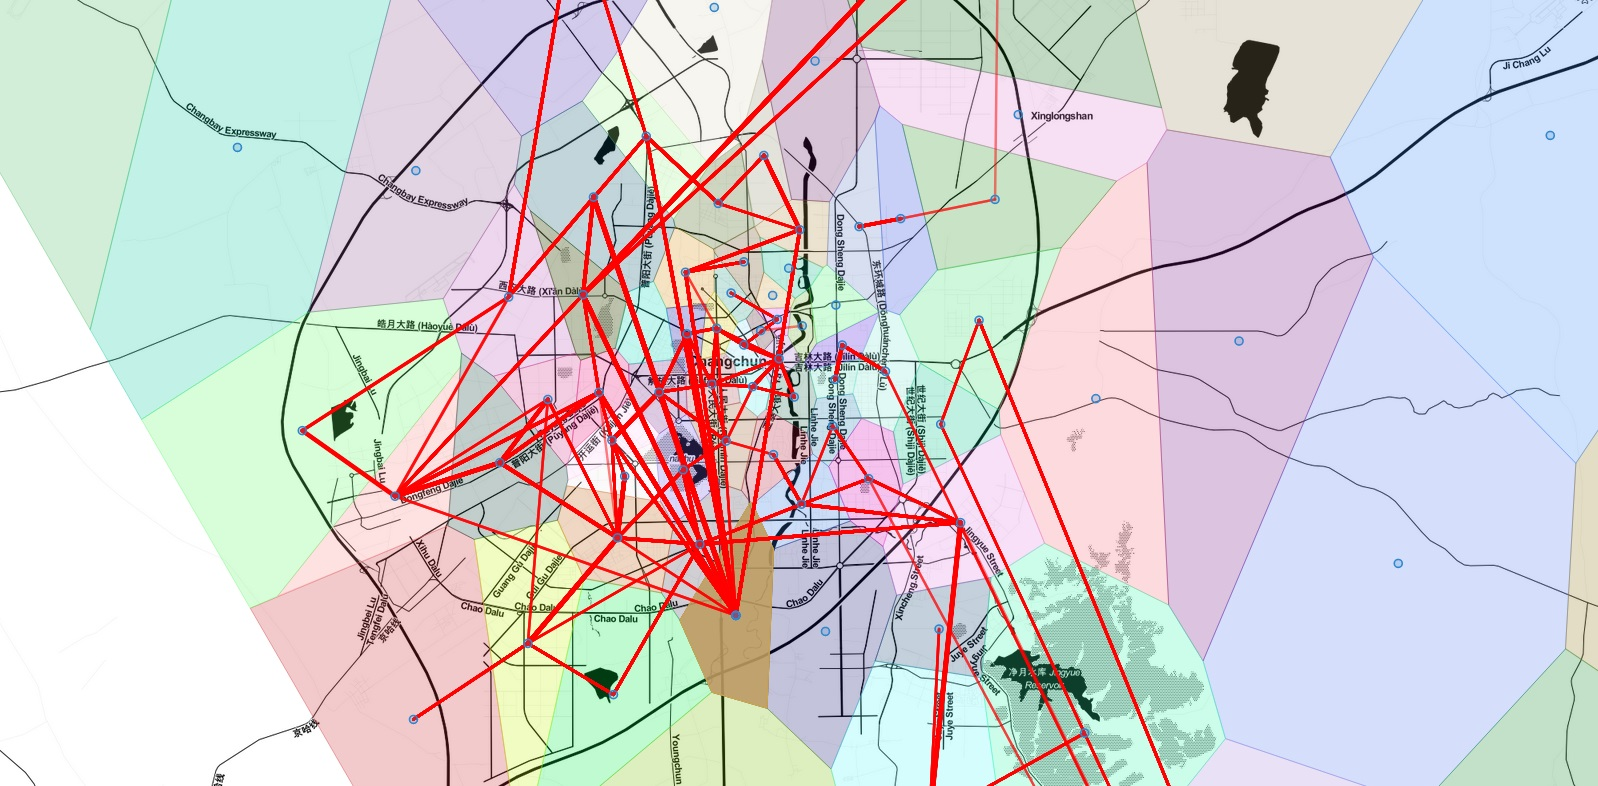